Extracted data saved to extracted_data.csv


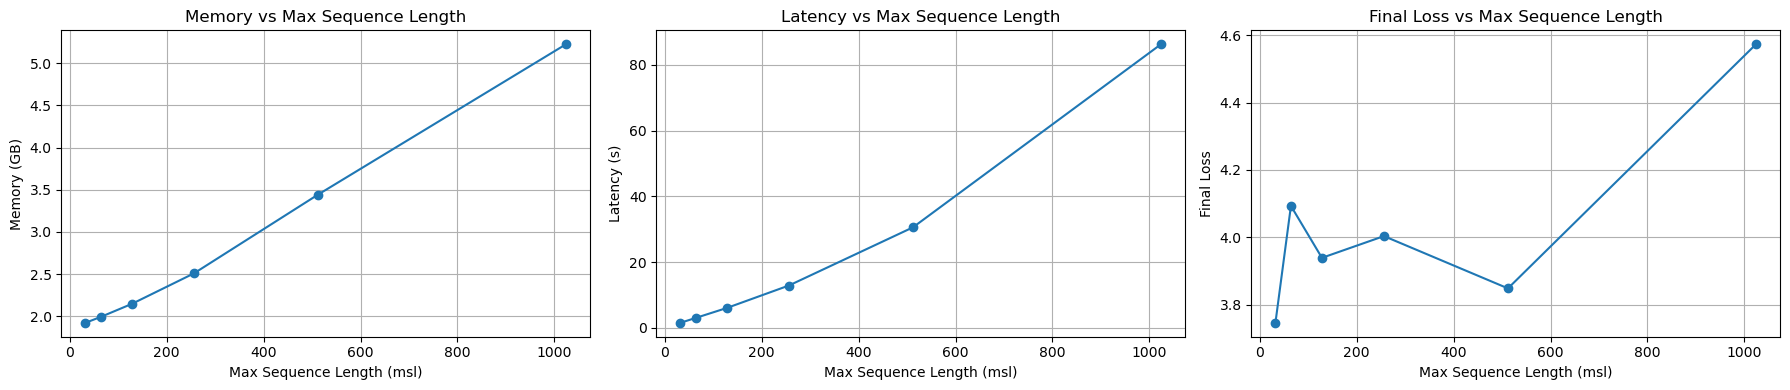

In [29]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

def extract_data(folder_path):
    data = []

    # List all files in the folder
    for file_name in os.listdir(folder_path):
        # Process memory files
        if file_name.startswith("memory_bs1_msl") and file_name.endswith("modelgpt2_124M.bin.log"):
            msl_match = re.search(r"msl(\d+)", file_name)
            if not msl_match:
                continue
            msl = int(msl_match.group(1))

            # Read memory data
            memory_file_path = os.path.join(folder_path, file_name)
            with open(memory_file_path, 'r', errors='ignore') as memory_file:
                # Skip the first 150 lines
                for _ in range(150):
                    next(memory_file, None)  # Safely skip lines without throwing an error
                # Read memory usage from the remaining lines
                memory = None
                for line in memory_file:
                    memory_match = re.search(r"ProcessMem=(\d+)", line)
                    if memory_match:
                        memory = int(memory_match.group(1))
                        break  # Use the first valid memory value after skipping

            # Find corresponding run file
            run_file_name = f"run_bs1_msl{msl}_modelgpt2_124M.bin.log"
            run_file_path = os.path.join(folder_path, run_file_name)
            if os.path.exists(run_file_path):
                with open(run_file_path, 'r', errors='ignore') as run_file:
                    latency, val_loss = None, None
                    for i, line in enumerate(run_file):
                        if i >= 4:  # Look for latency at step 5
                            latency_match = re.search(r"took ([\d.]+) ms", line)
                            if latency_match:
                                latency = float(latency_match.group(1))
                        val_loss_match = re.search(r"val loss ([\d.]+)", line)
                        if val_loss_match:
                            val_loss = float(val_loss_match.group(1))

                    if latency is not None and val_loss is not None and memory is not None:
                        data.append({
                            "msl": msl,
                            "memory": memory / (1024 * 1024),  # Convert KB to GB
                            "latency": latency / 1000,  # Convert ms to s
                            "val_loss": val_loss
                        })
    return pd.DataFrame(data)

def plot_data_with_subplots(df):
    # Sort data by msl to ensure the line connects points in ascending order
    df = df.sort_values("msl")

    # Create a 1-row, 3-column subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Plot memory vs msl
    axes[0].plot(df['msl'], df['memory'], marker='o', linestyle='-', label='Memory')
    axes[0].set_xlabel("Max Sequence Length (msl)")
    axes[0].set_ylabel("Memory (GB)")
    axes[0].set_title("Memory vs Max Sequence Length")
    axes[0].grid(True)

    # Plot latency vs msl
    axes[1].plot(df['msl'], df['latency'], marker='o', linestyle='-', label='Latency')
    axes[1].set_xlabel("Max Sequence Length (msl)")
    axes[1].set_ylabel("Latency (s)")
    axes[1].set_title("Latency vs Max Sequence Length")
    axes[1].grid(True)

    # Plot final loss vs msl
    axes[2].plot(df['msl'], df['val_loss'], marker='o', linestyle='-', label='Final Loss')
    axes[2].set_xlabel("Max Sequence Length (msl)")
    axes[2].set_ylabel("Final Loss")
    axes[2].set_title("Final Loss vs Max Sequence Length")
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.savefig("metrics_vs_msl.png")
    plt.show()

# Main execution
folder_path = "./logs"  # Replace with your logs folder path
data_frame = extract_data(folder_path)

# Save the extracted data to CSV
data_frame.to_csv("extracted_data.csv", index=False)
print("Extracted data saved to extracted_data.csv")

# Plot the data
plot_data_with_subplots(data_frame)

Extracted data saved to extracted_data_bs.csv


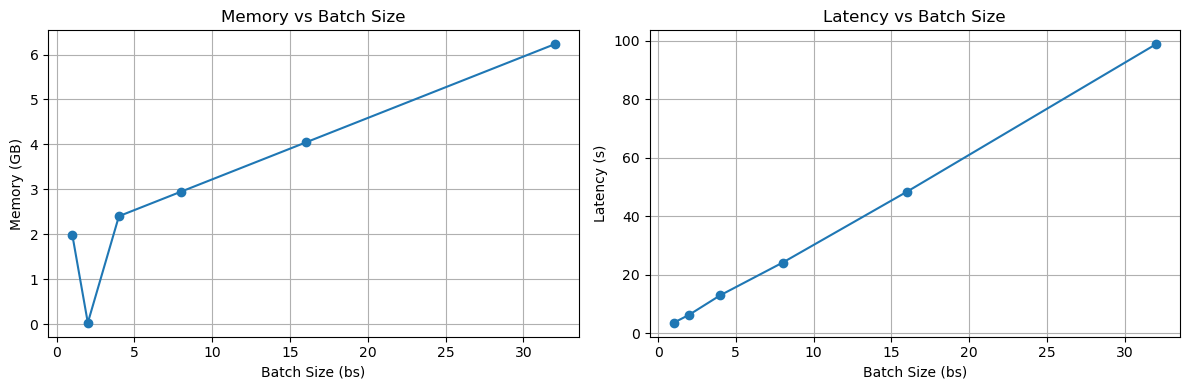

In [30]:
def extract_data_for_bs(folder_path):
    data = []

    # List all files in the folder
    for file_name in os.listdir(folder_path):
        # Process memory files
        if file_name.startswith("memory_bs") and "msl64_modelgpt2_124M.bin.log" in file_name:
            bs_match = re.search(r"bs(\d+)", file_name)
            if not bs_match:
                continue
            bs = int(bs_match.group(1))

            # Read memory data
            memory_file_path = os.path.join(folder_path, file_name)
            with open(memory_file_path, 'r', errors='ignore') as memory_file:
                for line in memory_file: 
                    # Skip the first 200 lines
                    for _ in range(150):
                        next(memory_file)
                    memory_match = re.search(r"ProcessMem=(\d+)", line)
                    if memory_match:
                        memory = int(memory_match.group(1))
                        break  # Use the first memory value and stop reading

            # Find corresponding run file
            run_file_name = f"run_bs{bs}_msl64_modelgpt2_124M.bin.log"
            run_file_path = os.path.join(folder_path, run_file_name)
            if os.path.exists(run_file_path):
                with open(run_file_path, 'r', errors='ignore') as run_file:
                    latency = None
                    for i, line in enumerate(run_file):
                        if i >= 4:  # Look for latency at step 5
                            latency_match = re.search(r"took ([\d.]+) ms", line)
                            if latency_match:
                                latency = float(latency_match.group(1)) / 1000  # Convert ms to s
                                break

                    if latency is not None:
                        data.append({
                            "bs": bs,
                            "memory": memory / (1024 * 1024),  # Convert KB to GB
                            "latency": latency
                        })
    return pd.DataFrame(data)

def plot_bs_vs_metrics(df):
    # Sort data by batch size to ensure the line connects points in ascending order
    df = df.sort_values("bs")

    # Create a 1-row, 2-column subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot memory vs bs
    axes[0].plot(df['bs'], df['memory'], marker='o', linestyle='-', label='Memory')
    axes[0].set_xlabel("Batch Size (bs)")
    axes[0].set_ylabel("Memory (GB)")
    axes[0].set_title("Memory vs Batch Size")
    axes[0].grid(True)

    # Plot latency vs bs
    axes[1].plot(df['bs'], df['latency'], marker='o', linestyle='-', label='Latency')
    axes[1].set_xlabel("Batch Size (bs)")
    axes[1].set_ylabel("Latency (s)")
    axes[1].set_title("Latency vs Batch Size")
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.savefig("metrics_vs_bs.png")
    plt.show()

# Main execution
folder_path = "./logs"  # Replace with your logs folder path
data_frame_bs = extract_data_for_bs(folder_path)

# Save the extracted data to CSV
data_frame_bs.to_csv("extracted_data_bs.csv", index=False)
print("Extracted data saved to extracted_data_bs.csv")

# Plot the data
plot_bs_vs_metrics(data_frame_bs)

No valid memory data in file: memory_bs1_msl512_modelgpt2_355M.bin.log
     msl model_size    memory    latency  val_loss
0     16       124M  1.889100   0.843959  4.363003
1     64       124M  1.993162   3.071532  4.093129
2    128       124M  2.147348   6.089388  3.938801
3     16       355M  5.356211   2.579583  4.284024
4     64       355M  5.573063   9.337974  3.960491
5    128       355M  5.903307  18.727606  3.891543
6    512       124M  3.441681  30.589107  3.848077
7      8       124M  1.872795   0.505313  4.510271
8      2       124M  1.861135   0.262272  6.342315
9      1       355M  5.294930   0.592675  6.977594
10  1024       124M  6.151856  86.251005  4.573292
11     2       355M  5.298406   0.751453  7.164142
12     8       355M  5.322691   1.526926  4.563434
13     1       124M  1.859703   0.202152  6.672086
14     4       355M  5.306320   1.156236  5.154606
15    32       355M  5.425547   4.850474  3.710453
16   256       124M  2.508474  12.910317  4.003394
17     4   

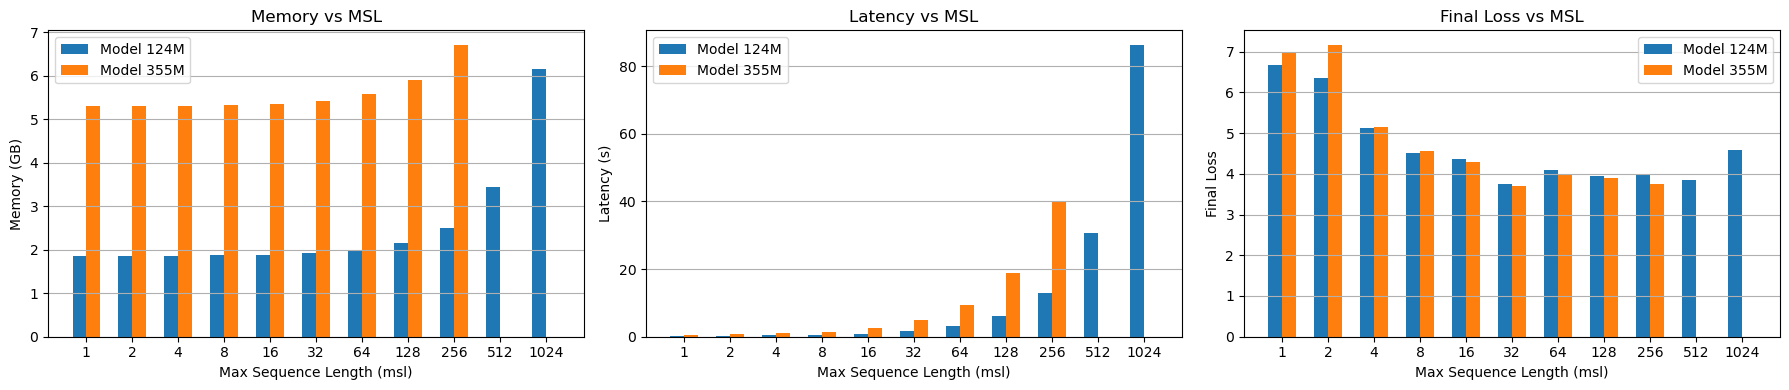

In [60]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_data_for_bar_chart(folder_path):
    data = []

    # List all memory files in the folder
    for file_name in os.listdir(folder_path):
        if not file_name.startswith("memory"):
            continue

        # Match memory files for bs1 and models 124M and 355M
        memory_match = re.search(r"bs1_msl(\d+)_modelgpt2_(\d+M)", file_name)
        if not memory_match:
            continue
        msl = int(memory_match.group(1))
        model_size = memory_match.group(2)

        # Read memory data
        memory_file_path = os.path.join(folder_path, file_name)
        try:
            with open(memory_file_path, 'r', errors='ignore') as memory_file:
                lines = memory_file.readlines()
                if len(lines) >= 20:  # Ensure the file has enough lines
                    memory_line = lines[-20]  # Get the 20th last line
                    memory_data_match = re.search(r"ProcessMem=(\d+)", memory_line)
                    if memory_data_match:
                        memory = int(memory_data_match.group(1)) / (1024 * 1024)  # Convert KB to GB
                    else:
                        print(f"No valid memory data in file: {file_name}")
                        memory = None
                else:
                    print(f"File too short: {file_name}")
                    memory = None
        except Exception as e:
            print(f"Error reading memory file {memory_file_path}: {e}")
            memory = None

        # Skip if memory could not be extracted
        if memory is None:
            continue

        # Find corresponding run file
        run_file_name = f"run_bs1_msl{msl}_modelgpt2_{model_size}.bin.log"
        run_file_path = os.path.join(folder_path, run_file_name)
        latency, val_loss = None, None
        if os.path.exists(run_file_path):
            try:
                with open(run_file_path, 'r', errors='ignore') as run_file:
                    for i, line in enumerate(run_file):
                        if i >= 4:  # Look for latency at step 5
                            latency_match = re.search(r"took ([\d.]+) ms", line)
                            if latency_match:
                                latency = float(latency_match.group(1)) / 1000  # Convert ms to s
                        val_loss_match = re.search(r"val loss ([\d.]+)", line)
                        if val_loss_match:
                            val_loss = float(val_loss_match.group(1))
            except Exception as e:
                print(f"Error reading run file {run_file_path}: {e}")
                latency, val_loss = None, None
        else:
            print(f"Run file not found for memory file: {file_name}")
            continue  # Skip if run file does not exist

        # Append the extracted data if all metrics are valid
        if latency is not None and val_loss is not None:
            data.append({
                "msl": msl,
                "model_size": model_size,
                "memory": memory,
                "latency": latency,
                "val_loss": val_loss
            })

    return pd.DataFrame(data)

def plot_bar_charts(df):
    # Sort data by msl
    df = df.sort_values("msl")

    # Unique msl and model sizes
    msl_values = sorted(df["msl"].unique())
    model_sizes = sorted(df["model_size"].unique())

    # Create a bar chart for each metric
    metrics = ["memory", "latency", "val_loss"]
    metric_labels = ["Memory (GB)", "Latency (s)", "Final Loss"]
    titles = ["Memory vs MSL", "Latency vs MSL", "Final Loss vs MSL"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    for i, metric in enumerate(metrics):
        ax = axes[i]
        width = 0.3  # Width of the bars
        x = np.arange(len(msl_values))  # X-axis positions for msl

        for j, model_size in enumerate(model_sizes):
            # Filter data for the current model size
            model_data = df[df["model_size"] == model_size]
            y = [model_data[model_data["msl"] == msl][metric].values[0] if not model_data[model_data["msl"] == msl].empty else 0 for msl in msl_values]
            ax.bar(x + j * width, y, width=width, label=f"Model {model_size}")

        # Customize the plot
        ax.set_xlabel("Max Sequence Length (msl)")
        ax.set_ylabel(metric_labels[i])
        ax.set_title(titles[i])
        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(msl_values)
        ax.legend()
        ax.grid(True, axis="y")

    plt.tight_layout()
    plt.savefig("metrics_bar_charts.png")
    plt.show()

# Main execution
folder_path = "./logs"  # Replace with your logs folder path
data_frame = extract_data_for_bar_chart(folder_path)

print(data_frame)
# Save the extracted data to CSV
data_frame.to_csv("extracted_bar_chart_data.csv", index=False)
print("Extracted data saved to extracted_bar_chart_data.csv")

# Plot the bar charts
plot_bar_charts(data_frame)